In [4]:
import NN_Functions as nn_func
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import sys
import copy

In [5]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

testing_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [6]:
batch_size = 60
testing_batch_size = 10
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_data, batch_size = testing_batch_size, shuffle=True)

In [11]:
class ANN:

    def __init__(self, layers, Loss, hid_nonl, out_act,ini_w,ini_b,epsilon,lr):
        self.num_layers = len(layers)
        self.iw = ini_w
        self.ib = ini_b
        self.Loss = Loss
        self.hid_nonl = hid_nonl
        self.out_act = out_act
        self.biases = [np.random.uniform(-self.ib,self.ib, (y, 1)) for y in layers[1:]]
        self.weights = [np.random.uniform(-self.iw,self.iw, (y, x)) for x, y in zip(layers[:-1], layers[1:])]
        self.loss = 0
        self.epsilon = epsilon
        self.lr = lr
        self.delta_biases = []
        self.delta_weights = []
        self.sum_biases = []
        self.sum_weights = []
        sum_b = [np.sum(b) for b in self.biases]
        sum_w = [np.sum(w) for w in self.weights]
        self.sum_biases.append(tuple(sum_b))
        self.sum_weights.append(tuple(sum_w))


    def printf(self):
        print('self.biases', *self.biases)
        print('self.weights', *self.weights)

    def forward(self, x):
        print(x.shape)
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            x = self.hid_nonl.activation(w@x + b)
        x = self.out_act.activation(self.weights[-1] @ x + self.biases[-1])

        return x
    
    def update(self, batch_input, batch_label, lr):
        
        
        grad_sum_b = [np.zeros(b.shape) for b in self.biases]
        grad_sum_w = [np.zeros(w.shape) for w in self.weights]
        input = batch_input.numpy().reshape((batch_size, 1, 784, 1))
        label = np.zeros((batch_size, 1, 10, 1))
        label[np.arange(batch_size),:,batch_label,:] = 1  
        
        
        delta_b, delta_w, batch_loss = self.backprop(input, label)

        grad_sum_b = [b_sum + dlt_b[:,0,:,:].sum(axis = 0) for b_sum, dlt_b in zip(grad_sum_b, delta_b)]
        grad_sum_w = [w_sum + dlt_w[:,0,:,:].sum(axis = 0) for w_sum, dlt_w in zip(grad_sum_w, delta_w)]
        
        '''
        check graident approximation with backprop
        '''
        # print('grad_sum_b', *grad_sum_b, sep = '\n')
        # print('grad_sum_w', *grad_sum_w, sep = '\n')

        self.loss += batch_loss
        self.weights = [w - (lr/batch_size) * nw for w, nw in zip(self.weights, grad_sum_w)]
        self.biases = [b - (lr/batch_size) * nb for b, nb in zip(self.biases, grad_sum_b)]
        
        sum_b = [np.sum(b) for b in self.biases]
        sum_w = [np.sum(w) for w in self.weights]
        self.sum_biases.append(tuple(sum_b))
        self.sum_weights.append(tuple(sum_w))


        
        temp_b = [np.sum(b) for b in grad_sum_b]
        temp_w = [np.sum(w) for w in grad_sum_w]
        self.delta_biases.append(tuple(temp_b))
        self.delta_weights.append(tuple(temp_w))
        
    def gradient_approximation(self, batch_input, batch_label):
        nabla_b = [ np.zeros(b.shape) for b in self.biases]
        nabla_w = [ np.zeros(w.shape) for w in self.weights]
        aprox1_b = [ np.zeros(b.shape) for b in self.biases]
        aprox2_b = [ np.zeros(b.shape) for b in self.biases]
        aprox1_w = [ np.zeros(w.shape) for w in self.weights]
        aprox2_w = [ np.zeros(w.shape) for w in self.weights]

        x = batch_input.numpy().reshape((batch_size, 1, 784, 1))
        y = np.zeros((batch_size, 1, 10, 1))
        y[np.arange(batch_size),:,batch_label,:] = 1  
        
        
        # b[-1]: 
        for i in range(len(self.biases)):
            for j in range(len(self.biases[i])):
                x1 = x
                x2 = x
                aprox1_b = copy.deepcopy(self.biases)
                aprox2_b = copy.deepcopy(self.biases)
                aprox1_b[i][j] += self.epsilon
                aprox2_b[i][j] -= self.epsilon


                for b, w in zip(aprox1_b[:-1], self.weights[:-1]):
                    x1 = self.hid_nonl.activation(w @ x1 + b)
                    
                x1 = self.out_act.activation(self.weights[-1] @ x1 + aprox1_b[-1]) 

                for b, w in zip(aprox2_b[:-1], self.weights[:-1]):
                    x2 = self.hid_nonl.activation(w @ x2 + b)
        
                x2 = self.out_act.activation(self.weights[-1] @ x2 + aprox2_b[-1]) 

                nabla_b[i][j] = np.sum((self.Loss.Loss(x1, y) - self.Loss.Loss(x2, y)) / (2*self.epsilon)) 
                
                
        for i in range(len(self.weights)):
            for j in range(len(self.weights[i])):
                for k in range (len(self.weights[i][j])):
                    x1 = x
                    x2 = x
                    aprox1_w = copy.deepcopy(self.weights)
                    aprox2_w = copy.deepcopy(self.weights)
                    aprox1_w[i][j][k] = (1+self.epsilon) * aprox1_w[i][j][k]
                    aprox2_w[i][j][k] = (1-self.epsilon) * aprox2_w[i][j][k]

                    for b, w in zip(self.biases[:-1], aprox1_w[:-1]):
                        x1 = self.hid_nonl.activation(w @ x1 + b)
                    x1 = self.out_act.activation(aprox1_w[-1] @ x1 + self.biases[-1]) 

                    for b, w in zip(self.biases[:-1], aprox2_w[:-1]):
                        x2 = self.hid_nonl.activation(w @ x2 + b)
                    x2 = self.out_act.activation(aprox2_w[-1] @ x2 + self.biases[-1]) 

                    nabla_w[i][j][k] = np.sum((self.Loss.Loss(x1, y) - self.Loss.Loss(x2, y)) / (2*self.epsilon)) 
               
        return (nabla_b, nabla_w)
        
    def backprop(self, x, y):
        nabla_b = [np.zeros((batch_size,1,) + b.shape) for b in self.biases]
        nabla_w = [np.zeros((batch_size,1,) + w.shape) for w in self.weights]
        
        #print(x)
        activation = x
        activations = [x] 
        z_vector = [] # weighted input
        loss = 0
        
        for b, w in zip(self.biases[:-1], self.weights[:-1]):
            z = w @ activation + b
            z_vector.append(z)
            activation = self.hid_nonl.activation(z)
            activations.append(activation)
           
        z = self.weights[-1] @ activation + self.biases[-1]  
        z_vector.append(z)
        activation = self.out_act.activation(z)
        activations.append(activation)
        
        loss = self.Loss.Loss(activation, y)
        
        if self.out_act.fast() + self.Loss.fast() == 2: 
            delta = (nn_func.softmax_XE_grad(activations[-1] , y))
            
        else: 
            delta = np.transpose(self.out_act.gradient(z_vector[-1]),(0, 1, 3, 2)) @ self.Loss.gradient(activations[-1], y)

            
        nabla_b[-1] = delta
        nabla_w[-1] = delta @ np.transpose(activations[-2],(0, 1, 3, 2))

        for l in range(2, self.num_layers):
            delta = np.transpose(self.hid_nonl.gradient(z_vector[-l]),(0, 1, 3, 2)) @ np.transpose(self.weights[-l+1]) @ delta
            nabla_b[-l] = delta
            nabla_w[-l] = delta @ np.transpose(activations[-l-1],(0, 1, 3, 2))

        return (nabla_b, nabla_w, loss)

In [12]:
net_structure = [784,50,50,10]

In [13]:
my_net = ANN(net_structure, Loss = nn_func.XE(), hid_nonl = nn_func.leaky_relu(0.1), out_act = nn_func.Softmax(),ini_w = 1,ini_b = 1,epsilon = 1e-10,lr = 0.05)

In [14]:
%%time
EPOCHS = 300

training_loss = []
training_count = []
validation_loss = []
validation_count = []

for epoch in range(EPOCHS):
    
    train_count = 0
    for i, (input, label) in enumerate(train_dataloader): 
        batch_size = 60
        # nabla_b1, nabla_w1 = my_net.gradient_approximation(input, label)
        my_net.update(input, label , lr = my_net.lr)
        predicted = my_net.forward(input.numpy().reshape(batch_size,1,784,1))
        predicted = np.argmax(predicted , axis = 2).reshape(batch_size,1)
        
        label = label.numpy().reshape(batch_size,1)
        count = batch_size - np.count_nonzero(predicted - label)
        train_count += count 

        
    train_count = train_count / (batch_size*len(train_dataloader))
    train_loss = my_net.loss / (batch_size*len(train_dataloader))
    training_loss.append(train_loss)
    training_count.append(train_count)
    
    
    valid_loss= 0
    valid_count = 0
    for input, label in testing_dataloader:
        batch_size = testing_batch_size
        predicted = my_net.forward(input.numpy().reshape(batch_size,1,784,1))
        one_hot_encoded_label = np.zeros((batch_size, 1, 10, 1))
        one_hot_encoded_label[np.arange(batch_size),:,label,:] = 1 
        valid_loss += my_net.Loss.Loss(predicted, one_hot_encoded_label)
        label = label.numpy().reshape(batch_size,1)
        predicted = np.argmax(predicted , axis = 2).reshape(batch_size,1)
        count = batch_size - np.count_nonzero(predicted - label)
        valid_count += count 
    
    valid_loss = valid_loss / (batch_size*len(testing_dataloader))
    valid_count = valid_count / (batch_size*len(testing_dataloader))
    validation_loss.append(valid_loss)
    validation_count.append(valid_count)
    print('Epoch: {} | training_loss: {} | training_accuracy: {}% | validation_loss: {} | validation_accuracy: {}%'.format(epoch, train_loss, train_count*100, valid_loss, valid_count*100))
    my_net.loss = 0

delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (6

(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 784, 1)
delta (60, 1, 10, 1)
transpose (60, 1, 1, 50)
(60, 1, 

KeyboardInterrupt: 

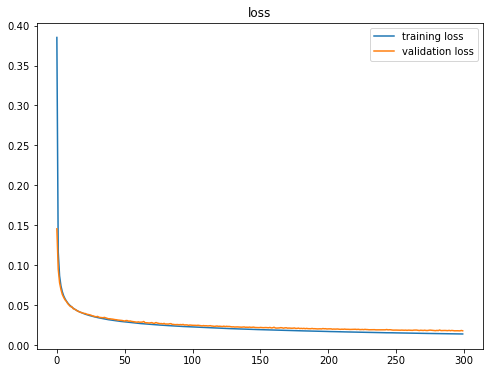

In [8]:
plt.figure(figsize = (8, 6))
plt.plot(training_loss, label = 'training loss', markersize = 3)
plt.plot(validation_loss, label = 'validation loss', markersize = 3)
plt.title("loss")
plt.legend()
plt.show()

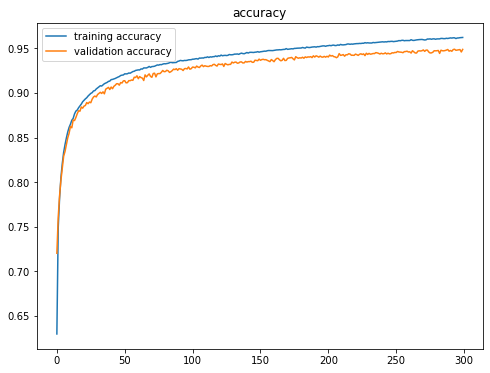

In [9]:
plt.figure(figsize = (8, 6))
plt.plot(training_count, label = 'training accuracy', markersize = 3)
plt.plot(validation_count, label = 'validation accuracy', markersize = 3)
plt.title("accuracy")
plt.legend()
plt.show()

#### 

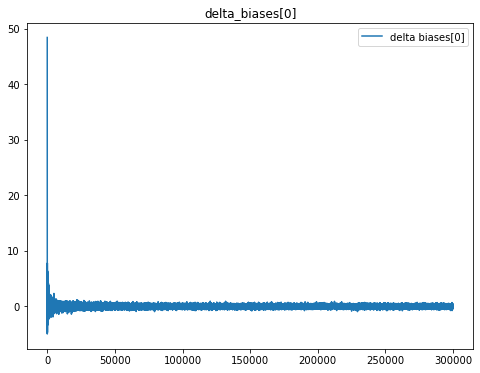

In [10]:
delta_biases = list(zip(*my_net.delta_biases))
plt.figure(figsize = (8, 6))
plt.plot(delta_biases[0], label = 'delta biases[0]', markersize = 3)
plt.title("delta_biases[0]")
plt.legend()
plt.show()

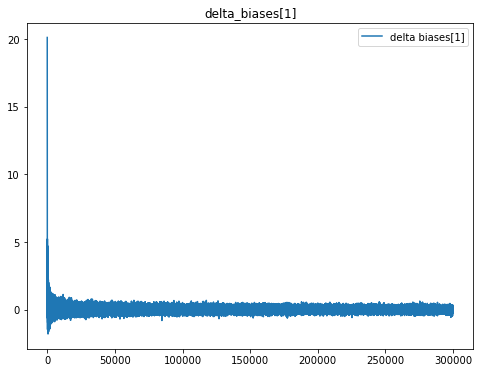

In [11]:
plt.figure(figsize = (8, 6))
plt.plot(delta_biases[1], label = 'delta biases[1]', markersize = 3)
plt.title("delta_biases[1]")
plt.legend()
plt.show()

In [12]:
'''
plt.figure(figsize = (8, 6))
plt.plot(delta_biases[2], label = 'delta biases[2]', markersize = 3)
plt.title("delta_biases[2]")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize = (8, 6))\nplt.plot(delta_biases[2], label = \'delta biases[2]\', markersize = 3)\nplt.title("delta_biases[2]")\nplt.legend()\nplt.show()\n'

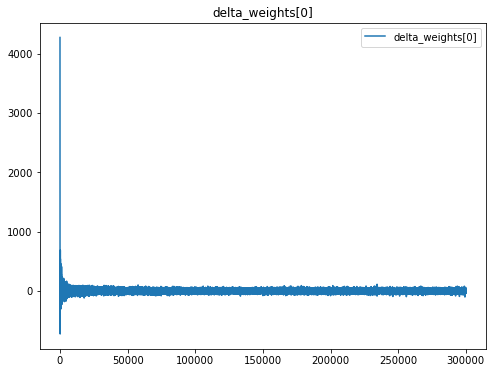

In [13]:
delta_weights = list(zip(*my_net.delta_weights))
plt.figure(figsize = (8, 6))
plt.plot(delta_weights[0], label = 'delta_weights[0]', markersize = 3)
plt.title("delta_weights[0]")
plt.legend()
plt.show()

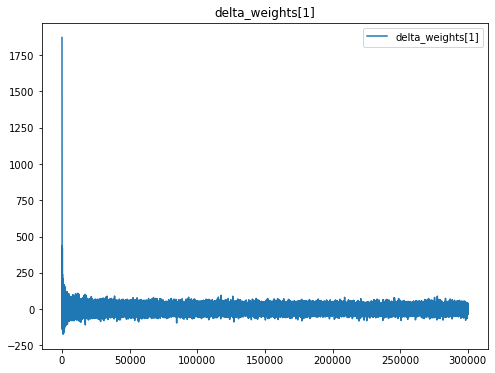

In [14]:
plt.figure(figsize = (8, 6))
plt.plot(delta_weights[1], label = 'delta_weights[1]', markersize = 3)
plt.title("delta_weights[1]")
plt.legend()
plt.show()

In [15]:
'''
plt.figure(figsize = (8, 6))
plt.plot(delta_weights[2], label = 'delta_weights[2]', markersize = 3)
plt.title("delta_weights[2]")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize = (8, 6))\nplt.plot(delta_weights[2], label = \'delta_weights[2]\', markersize = 3)\nplt.title("delta_weights[2]")\nplt.legend()\nplt.show()\n'

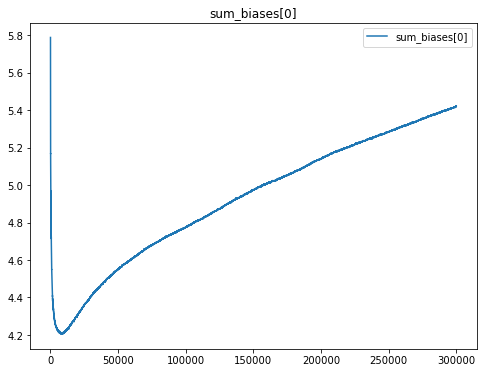

In [16]:
sum_biases = list(zip(*my_net.sum_biases))
plt.figure(figsize = (8, 6))
plt.plot(sum_biases[0], label = 'sum_biases[0]', markersize = 3)
plt.title("sum_biases[0]")
plt.legend()
plt.show()

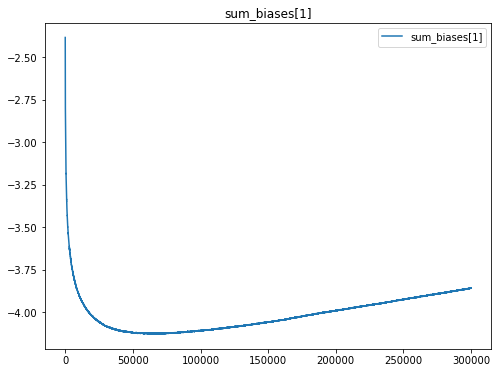

In [17]:
plt.figure(figsize = (8, 6))
plt.plot(sum_biases[1], label = 'sum_biases[1]', markersize = 3)
plt.title("sum_biases[1]")
plt.legend()
plt.show()

In [18]:
'''
plt.figure(figsize = (8, 6))
plt.plot(sum_biases[2], label = 'sum_biases[2]', markersize = 3)
plt.title("sum_biases[2]")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize = (8, 6))\nplt.plot(sum_biases[2], label = \'sum_biases[2]\', markersize = 3)\nplt.title("sum_biases[2]")\nplt.legend()\nplt.show()\n'

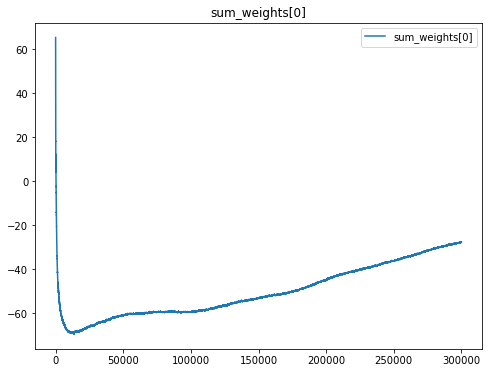

In [19]:
sum_weights = list(zip(*my_net.sum_weights))
plt.figure(figsize = (8, 6))
plt.plot(sum_weights[0], label = 'sum_weights[0]', markersize = 3)
plt.title("sum_weights[0]")
plt.legend()
plt.show()

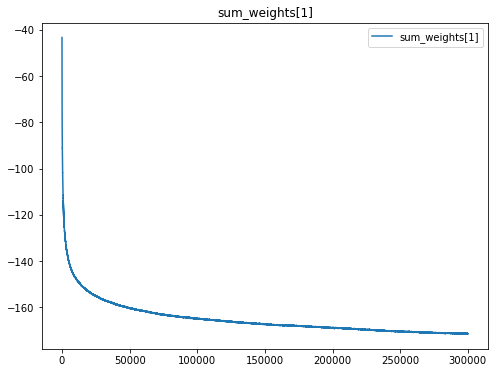

In [20]:
plt.figure(figsize = (8, 6))
plt.plot(sum_weights[1], label = 'sum_weights[1]', markersize = 3)
plt.title("sum_weights[1]")
plt.legend()
plt.show()

In [21]:
'''
plt.figure(figsize = (8, 6))
plt.plot(sum_weights[2], label = 'sum_weights[2]', markersize = 3)
plt.title("sum_weights[2]")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize = (8, 6))\nplt.plot(sum_weights[2], label = \'sum_weights[2]\', markersize = 3)\nplt.title("sum_weights[2]")\nplt.legend()\nplt.show()\n'